# Extract features from the dataset

In [1]:
import json
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import networkx as nx
import numpy as np

import copy
import matplotlib.pyplot as plt
##### model
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec
from sklearn.cluster import DBSCAN


import warnings
import collections
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import torch
from torch_geometric.utils.convert import from_networkx


%matplotlib inline



/Users/yanircohen/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# crate a list to add dataframes to
awsc_list = list()

# list of files
files_list = ['../Datasets/flaws_cloudtrail00.json']

# Load event names
category_file = open("../Utils/event_category.json")
event_categories = json.load(category_file)
category_file.close()

encoder = OneHotEncoder(handle_unknown='ignore')
label_encoder = LabelEncoder()

In [3]:
starts_with_di = {
    'CreateObject': ['request','create','copy','run','purchase','allocate','import'],
    'ModifyExistingResource': ['modify','update','set','tag','deregister','Deprecate','un','reject','register'],
    'ListResources' : ['list'],
    'Download/UploadObjects': ['getobjects','upload'],
    'GetInfo': ['describe','get','search'],
    'AssociateResources' : ['associate','put'],
    'Login' : ['assume','login','switch','renewrole','renewdelegate'],
    'RemovePermissions': ['remove'],
    'GrantPermissions': ['add','authorize']

}

contains_di = {
    'Delete': ['delet','terminate','revoke','drop','releaseaddress'] ,
    'DisableObjects': ['disabl','stop','cancel','unlink','suspend'],
    'EnableObjects': ['enabl','start','invoke','subscribe','test','complete'],
    'SensitiveInfo': ['send','accesskey','secretkey','token','invite','exportapi'],
    'Logout': ['exit'],
    'CreateObject': ['create','copy'],
    'ModifyExistingResource': ['failover','change','confirm','promote','reboot','rotate','replace','retire','detach','modify','update','set','tag','deregister','Deprecate','attach','upgrade','wipe','transfer','validate','publish'],
    'ListResources' : ['list'],
    'Download/UploadObjects': ['getobjects','upload'],
    'GetInfo': ['describe','get','view'],
    'AssociateResources' : ['associate','put'],
    'Login' : ['assume','login','renewrole','sign','forgot'],
    'Logout' : ['logout']

}

In [4]:
for file in files_list:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.loads(f.read())
        
        # Append the dataframes
        awsc_list.append(pd.DataFrame.from_records(data['Records']))

In [5]:
# Merge data frames into one 
awsc = pd.concat(awsc_list).reset_index(drop=True)

In [6]:
awsc[(awsc['eventSource']=='cognito-idp.amazonaws.com')]

,userAgent,eventID,userIdentity,eventType,sourceIPAddress,eventName,eventSource,recipientAccountId,requestParameters,awsRegion,...,eventVersion,eventTime,errorMessage,errorCode,apiVersion,readOnly,resources,additionalEventData,sharedEventID,vpcEndpointId


In [7]:
users = pd.json_normalize(awsc['userIdentity']).merge(awsc[['eventTime','eventName','eventSource','awsRegion','errorCode']], left_index=True,right_index=True)

In [8]:
users['userName'] = users['userName'].fillna(users['arn']).fillna(users['invokedBy']) \
.fillna(users['invokedBy']).fillna(users['principalId']).fillna('accountId')

In [9]:
users = users[['eventTime','type','userName','eventName','eventSource','awsRegion','errorCode']]
users = users.rename(columns = {'eventTime':'timestamp','userName':'Identifier','eventSource':'TargetService','errorCode':'Error'})


In [10]:
users.head()


,timestamp,type,Identifier,eventName,TargetService,awsRegion,Error
0,2017-02-12T19:57:06Z,Root,arn:aws:iam::811596193553:root,ListBuckets,s3.amazonaws.com,us-east-1,NaN
1,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,GetAccountPasswordPolicy,iam.amazonaws.com,us-east-1,NoSuchEntityException
2,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,GetAccountSummary,iam.amazonaws.com,us-east-1,NaN
3,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,ListAccountAliases,iam.amazonaws.com,us-east-1,NaN
4,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,ListMFADevices,iam.amazonaws.com,us-east-1,NaN


In [11]:
awsc.head()


,userAgent,eventID,userIdentity,eventType,sourceIPAddress,eventName,eventSource,recipientAccountId,requestParameters,awsRegion,...,eventVersion,eventTime,errorMessage,errorCode,apiVersion,readOnly,resources,additionalEventData,sharedEventID,vpcEndpointId
0,[S3Console/0.4],3038ebd2-c98a-4c65-9b6e-e22506292313,"{'type': 'Root', 'principalId': '811596193553'...",AwsApiCall,255.253.125.115,ListBuckets,s3.amazonaws.com,811596193553,None,us-east-1,...,1.04,2017-02-12T19:57:06Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,console.amazonaws.com,22a0d9b1-deea-4d39-827b-2af7050ed3f3,"{'type': 'Root', 'principalId': '811596193553'...",AwsApiCall,255.253.125.115,GetAccountPasswordPolicy,iam.amazonaws.com,811596193553,None,us-east-1,...,1.02,2017-02-12T19:59:10Z,The Password Policy with domain name 811596193...,NoSuchEntityException,NaN,NaN,NaN,NaN,NaN,NaN
2,console.amazonaws.com,9facf7ca-cb76-4b19-940c-3de6803f7efb,"{'type': 'Root', 'principalId': '811596193553'...",AwsApiCall,255.253.125.115,GetAccountSummary,iam.amazonaws.com,811596193553,None,us-east-1,...,1.02,2017-02-12T19:59:10Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,console.amazonaws.com,6596d3b4-7c98-40b1-867d-f317f1dbdc18,"{'type': 'Root', 'principalId': '811596193553'...",AwsApiCall,255.253.125.115,ListAccountAliases,iam.amazonaws.com,811596193553,None,us-east-1,...,1.02,2017-02-12T19:59:10Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,console.amazonaws.com,9f9d038c-e5a5-443e-83d5-4cf00941d399,"{'type': 'Root', 'principalId': '811596193553'...",AwsApiCall,255.253.125.115,ListMFADevices,iam.amazonaws.com,811596193553,None,us-east-1,...,1.02,2017-02-12T19:59:10Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
li = []
def change_name(name):
    if name in event_categories:
        return event_categories[name]
    for key,value in starts_with_di.items():
        for event_name in value:
            if name.lower().startswith(event_name):
                return key
    for key,value in contains_di.items():
        for event_name in value:
            if event_name in name.lower():
                return key
    li.append(name)

users['eventName'] = users['eventName'].apply(lambda name: change_name(name))

# users['eventName'] = pd.DataFrame({'eventName':encoder.fit_transform(users[['eventName']]).toarray().tolist()},)
# users = users.join(encoder_df)
# users = users.drop('eventName', axis=1)

In [13]:
users['timestamp'] = pd.to_datetime(users['timestamp']).map(pd.Timestamp.timestamp).map(int)
users = users.sort_values('timestamp',ascending=True,ignore_index=True)

In [14]:
def get_time_df(start,end,minutes,df,col='timestamp'):
    minutes = minutes * 60
    df_list = []
    while start < end:
        cur_df = df[(df[col] >= start) & (df[col] < start+minutes)]
        if len(cur_df):
            df_list.append(df[(df[col] >= start) & (df[col] < start+minutes)])
        start+=minutes
    return df_list

In [15]:
users['Identifier'] = users['Identifier'].apply(lambda x : x if (len(x.split(":"))!=2) else x.split(":")[0])
users.nunique()

timestamp        58647
type                 5
Identifier          26
eventName           11
TargetService       49
awsRegion           15
Error               60
dtype: int64

In [16]:
# With region
# users['identity-event'] = "source-"+users['Identifier'] + "|" + users['eventName']
# users['event-region'] = users['eventName'] + "|" + users['awsRegion']
# users['region-target'] = users['awsRegion'] + "|" + "target-"+ users['TargetService']

# Without region

users['identity-event'] = "source-"+users['Identifier'] + "|" + users['eventName']
users['event-target'] = users['eventName'] + "|" + "target-"+ users['TargetService']
users = users[users['eventName'].notna()]

# print("Number of nodes")

In [17]:
users.head()

,timestamp,type,Identifier,eventName,TargetService,awsRegion,Error,identity-event,event-target
0,1486929426,Root,arn:aws:iam::811596193553:root,ListResources,s3.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|ListReso...,ListResources|target-s3.amazonaws.com
1,1486929550,Root,arn:aws:iam::811596193553:root,GetInfo,iam.amazonaws.com,us-east-1,NoSuchEntityException,source-arn:aws:iam::811596193553:root|GetInfo,GetInfo|target-iam.amazonaws.com
2,1486929550,Root,arn:aws:iam::811596193553:root,GetInfo,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|GetInfo,GetInfo|target-iam.amazonaws.com
3,1486929550,Root,arn:aws:iam::811596193553:root,ListResources,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|ListReso...,ListResources|target-iam.amazonaws.com
4,1486929550,Root,arn:aws:iam::811596193553:root,ListResources,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|ListReso...,ListResources|target-iam.amazonaws.com


In [18]:
users['Identifier'] = users['Identifier'].apply(lambda x : f"source-{x}")
users['TargetService'] = users['TargetService'].apply(lambda x : f"target-{x}")
df_list = get_time_df(users['timestamp'].iloc[0],users['timestamp'].iloc[-1],60*60,users)
for i in df_list:
    print(len(i))
# print(len(df_list))

1387
2388
21
259
2189
3060
965
1235
1247
1423
400
1077
392
382
165
281
133
280
300
95
267
122
127
188
89
94
253
171
144
66
87
89
118
88
493
121
731
154
214
1034
24252
1171
185
280
300
1232
153
254
235
146
404
225
335
333
196
204
324
664
431
424
340
254
273
191
186
171
940
535
156
339
460
194
493
813
247
147
167
200
140
188
213
271
253
200
334
290
198
511
130
103
99
110
522
534
318
272
320
1545
2003
249
414
724
519
395
937
535
561
127
249
398
154
270
244
72
616
148
120
303
121
177
298
136
217
170
488
146
79
73
129
317
114
354
468
248
440
938
788
247
385
260
312
282
125
100
171
538
290
207
157
3522
681
94
170
146
103
108
223
320
161
486
135
86
320
129
122
175
158
124
115
537
5689


In [19]:
t = users.drop(columns=['Error'])
df1 = t[t.isna().any(axis=1)]
df1

,timestamp,type,Identifier,eventName,TargetService,awsRegion,identity-event,event-target


In [20]:
def add_nodes(g,df,col,x,jump=10):
    y = 10
    unique_nodes = df[col].unique()
    for i in unique_nodes:
        if i!= None:
            g.add_node(f'{i}',pos=(x,y))
            y+=jump
    for i in range(len(unique_nodes)-1):
        g.add_edge(unique_nodes[i],unique_nodes[i+1])

def add_edges(g,df,col):
    edges = df[col].value_counts()
    for node,value in edges.items():
        start_node,end_node = node.split('|')
        if "None" not in start_node and "None" not in end_node:
            g.add_edge(start_node, end_node, weight=1/value)

nodes = ['Identifier','eventName','TargetService']
edges = ['identity-event','event-target']
def generate_graph(G,df_nodes,df_edges):  
    x = 10
    for node in nodes:
        add_nodes(G,df_nodes,node,x,100)
        x+=1
        
#     for node in nodes:
#         if node!='eventName':
#             add_nodes(G,df,node,x,100)
#         else:
#             add_nodes(G,df,node,x,100)
#         x+=10
    # With region
#     add_nodes(G,df,'awsRegion')
#     add_edges(G,df,'identity-event')
#     add_edges(G,df,'event-region')
#     add_edges(G,df,'region-target')
    # Without region
    for edge in edges:
        add_edges(G,df_edges,edge)
        add_edges(G,df_edges,edge)
    

In [21]:
G = nx.Graph()
generate_graph(G,users,df_list[5])
# generate_graph(G,users,df_list[-3])

In [22]:
G.nodes()

NodeView(('source-arn:aws:iam::811596193553:root', 'source-backup', 'source-arn:aws:sts::811596193553:assumed-role/level6/level6-ec1335a148b902503664e2d162fcdaa98c224ea5', 'source-arn:aws:sts::811596193553:assumed-role/level6/level6', 'source-arn:aws:sts::811596193553:assumed-role/level5/level5', 'source-Level5', 'source-lambda.amazonaws.com', 'source-ec2.amazonaws.com', 'source-Level6', 'source-arn:aws:sts::811596193553:assumed-role/lambda_basic_execution/Level6', 'source-arn:aws:sts::811596193553:assumed-role/Level6/Level6', 'source-arn:aws:sts::811596193553:assumed-role/flaws/i-aa2d3b42e5c6e801a', 'source-piper', 'source-HIDDEN_DUE_TO_SECURITY_REASONS', 'source-AROANXSLA9JG22ZJM5176', 'source-arn:aws:sts::811596193553:assumed-role/Cloudsploit/cloudsploit_scan', 'source-SecurityMokey', 'source-arn:aws:sts::811596193553:assumed-role/SecurityMonkey/secmonkey', 'source-arn:aws:sts::811596193553:assumed-role/SecurityMonkey/cloudaux', 'source-AIDAS6VXHZ3PBMIBVP1P2', 'source-config.amazona

In [ ]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 10
# pos=nx.get_node_attributes(G,'pos')
# # pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
# d = dict(G.degree)
# nx.draw(G, pos, node_color='lightblue', 
#         with_labels=True, 
#         nodelist=d, 
#         node_size=[d[k]*300 for k in d])
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=5)
# import matplotlib.pyplot as plt
# plt.savefig('plotgraph.png', dpi=300, bbox_inches='tight')


# pos=nx.get_node_attributes(G,'pos')
# nx.draw(G,pos)

AttributeError: 'StellarGraph' object has no attribute 'is_multigraph'. The 'StellarGraph' type no longer inherits from NetworkX types: use a new StellarGraph method, or, if that is not possible, the `.to_networkx()` conversion function.

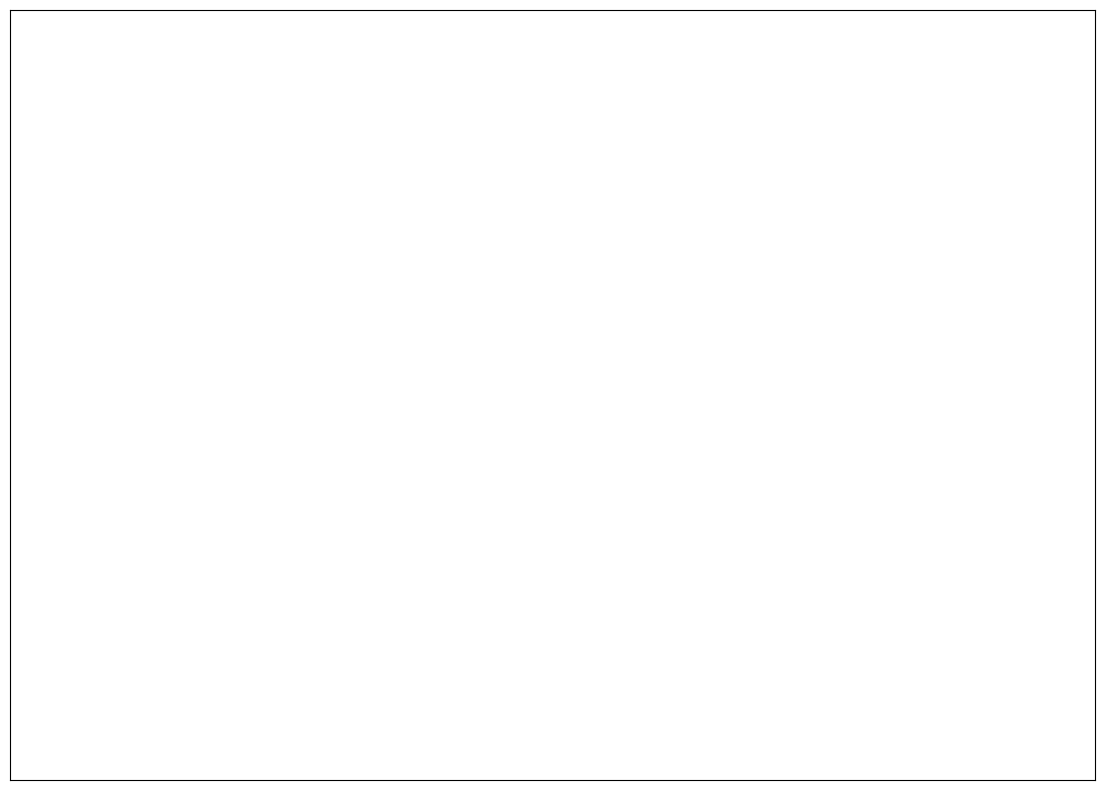

In [34]:
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
walk_length = 20  # maximum length of a random walk to use throughout this notebook

In [ ]:
G = StellarGraph.from_networkx(G)
rw = BiasedRandomWalk(G)

In [26]:
weighted_walks = rw.run(
  nodes=G.nodes(),  # root nodes
  length=walk_length,  # maximum length of a random walk
  n=10,  # number of random walks per root node
  p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
  q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
  weighted=True,  # for weighted random walks
  seed=42,  # random seed fixed for reproducibility
)

In [27]:
weighted_model = Word2Vec(
  weighted_walks, vector_size=128, window=5, min_count=0, sg=1, workers=1,
)

In [28]:
node_ids = weighted_model.wv.index_to_key  # list of node IDs
weighted_node_embeddings = (
  weighted_model.wv.vectors
) 

In [29]:
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

/var/folders/5l/hl528j5x65l97dh39f0mxwd00000gn/T/ipykernel_7034/3299656165.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


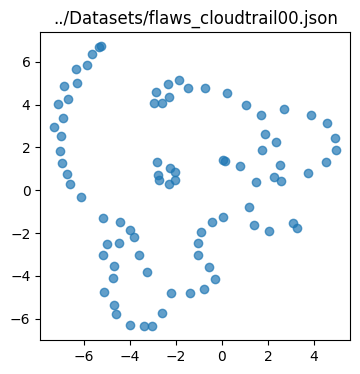

In [30]:
alpha = 0.7
#fig = plt.figure(figsize=(5,5))
#plt.subplot(1,len(files),num+1)
plt.figure(figsize=(4, 4))
plt.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    #c=node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
#plt.axis('off')
plt.title(file)
plt.show()

In [31]:
clustering = DBSCAN(eps=1, min_samples=5).fit(weighted_node_embeddings_2d)

In [32]:
clustering.labels_

array([ 0, -1, -1, -1, -1, -1,  2,  1,  1, -1,  2, -1,  3, -1, -1, -1,  1,
       -1, -1,  2, -1, -1,  0,  3,  2,  2,  1,  0, -1, -1, -1, -1, -1, -1,
       -1,  3,  1, -1,  2,  1,  2,  3,  1, -1,  3, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  3,  1, -1,  0, -1, -1, -1, -1, -1,  2, -1,  0,
       -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,  3, -1, -1, -1,  0, -1])

In [33]:
clustering

DBSCAN(eps=1)